# Imports

In [1]:
# General use libraries
import os
import random
import math
import typing

# Data related libraries
import numpy as np
import pandas as pd
from sktime.datasets import load_from_arff_to_dataframe
from scipy.signal import argrelextrema

# Plotting libraries
import seaborn
import matplotlib.pyplot as plt

# Features handling libraries
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2

# Parameters handling libraries
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Neural Networks
import tensorflow as tf

from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn import metrics

2022-05-04 18:01:28.038297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 18:01:28.038327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Utility functions

In [2]:
def combine_and_translate_classes(train_x: pd.DataFrame, train_y: np.array, class_labels: dict, classes_category: str) -> pd.DataFrame:
    y_dataframe = pd.DataFrame(data = train_y, columns=[classes_category])
    combined_data_frame =  pd.merge(train_x, y_dataframe, left_index=True, right_index=True, )
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        combined_data_frame.loc[combined_data_frame[classes_category] == class_label_key, classes_category] = class_label_value

    return combined_data_frame

def compute_grid_search_result(model_instance, parameters, X, y):
    grid_search_instance = GridSearchCV(model_instance, parameters)
    return grid_search_instance.fit(X, y)

def compute_metrics(y_actual, y_predicted):
    accuracy_score = metrics.accuracy_score(y_actual, y_predicted)
    precision_score = metrics.precision_score(y_actual, y_predicted, average=None)
    recall_score = metrics.recall_score(y_actual, y_predicted, average=None)
    f1_score = metrics.f1_score(y_actual, y_predicted, average=None)
    confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
    
    return {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "confusion_matrix": confusion_matrix
    }

def add_new_key_value_to_dict(dict, key, value):
    dict[key] = value
    return dict

def fit_predict_and_compute_metrics(model_definition, parameters, X_train, y_train, X_test, y_test):
    model_instance = model_definition(**parameters)
    model_instance.fit(X_train, y_train)
   
    y_predicted = model_instance.predict(X_test)
    return add_new_key_value_to_dict(compute_metrics(y_test, y_predicted), "parameters", parameters)

def fit_predict_and_compute_metrics_nn(model, train_x, train_y, test_x, test_y, batch_size, epochs, verbose=0):
    model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=verbose)
    prediction_distribution = model.predict(test_x)
    y_predicted = np.argmax(prediction_distribution, axis=1)
    return compute_metrics(test_y, y_predicted)

# Load data

In [3]:
PEMS_SF_DATA_PATH = "./PEMS-SF"
PEMS_SF_CLASSES_CATEGORY = "Day of the week"
PEMS_SF_CLASS_VALUES_MAPPER = {
    0 : "Monday",
    1 : "Tuesday",
    2 : "Wednesday",
    3 : "Thursday",
    4 : "Friday",
    5 : "Saturday",
    6 : "Sunday",
}

# Train data
train_x_pems_sf, train_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TRAIN.arff")
)
train_y_pems_sf = list(map(lambda x: int(float(x)) - 1, train_y_pems_sf))

# Test data
test_x_pems_sf, test_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TEST.arff")
)
test_y_pems_sf = list(map(lambda x: int(float(x)) - 1, test_y_pems_sf))

# Helpers for data visualization
pems_sf_columns = train_x_pems_sf.columns
pems_sf_train_translated = combine_and_translate_classes(\
    train_x_pems_sf, train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY)

pems_sf_results = {}

/home/samanu/.local/lib/python3.8/site-packages/sktime/datasets/_data_io.py:1108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_data["dim_" + str(dim)] = instance_list[dim]


In [4]:
U_WAVE_GESTURE_DATA_PATH = "./UWaveGestureLibrary"
U_WAVE_CLASSES_CATEGORY = "Gesture"
U_WAVE_GESTURE_CLASS_VALUES_MAPPER = {
    0 : "Gesture 1",
    1 : "Gesture 2",
    2 : "Gesture 3",
    3 : "Gesture 4",
    4 : "Gesture 5",
    5 : "Gesture 6",
    6 : "Gesture 7",
    7 : "Gesture 8",
}

U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER = {
    "Gesture 1" : "red",
    "Gesture 2" : "green",
    "Gesture 3" : "blue",
    "Gesture 4" : "yellow",
    "Gesture 5" : "brown",
    "Gesture 6" : "black",
    "Gesture 7" : "grey",
    "Gesture 8" : "orange",
}

# Train data
train_x_u_wave_gesture, train_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TRAIN.arff")
)
train_y_u_wave_gesture = list(map(lambda x: int(float(x)) - 1, train_y_u_wave_gesture))

# Test data
test_x_u_wave_gesture, test_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TEST.arff")
)
test_y_u_wave_gesture = list(map(lambda x: int(float(x)) - 1, test_y_u_wave_gesture))

# Helpers for data visualization
u_wave_gesture_train_translated = combine_and_translate_classes(\
    train_x_u_wave_gesture, train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY)

u_wave_gesture_results = {}

In [5]:
def get_np_array_from_data_frame(data_frame):
    return np.array(list(map(lambda row: list(map(lambda item: list(item), row)), np.array(data_frame))))

# #1 Exploratory Data Analysis

### #1.1 Class Equilibrium

In [6]:
def draw_class_equilibrium(y:np.array, class_labels, classes_category, count_label, title) -> None: 
    y_dataframe = pd.DataFrame(data = y, columns=[classes_category])
    y_dataframe[count_label] = 0
    y_dataframe = y_dataframe.groupby(classes_category, as_index=False).count()
    y_dataframe.reset_index()
    
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        y_dataframe.loc[y_dataframe[classes_category] == class_label_key, classes_category] = class_label_value
    
    y_dataframe.plot.bar(x = classes_category, y = count_label, title=title)
    plt.figure(figsize=(20, 5))
    plt.show()

##### #1.1.1 PEMS-SF
Some days of the weeks were skipped due to holidays or technical issues but the distribution wasn't changed so much.
<br/>
Count of classified days are somewhat similar.

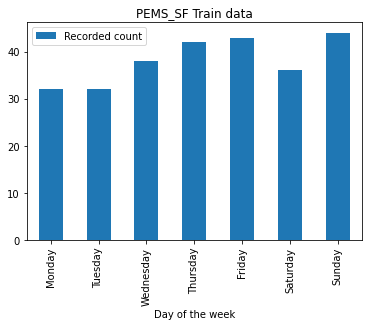

<Figure size 1440x360 with 0 Axes>

In [7]:
draw_class_equilibrium(train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Train data")

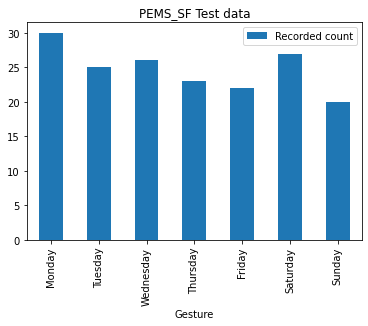

<Figure size 1440x360 with 0 Axes>

In [8]:
draw_class_equilibrium(test_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Test data")

##### #1.1.2 U_WAVE_GESTURE
This dataset is has an even class distribution both in train and test subsets.

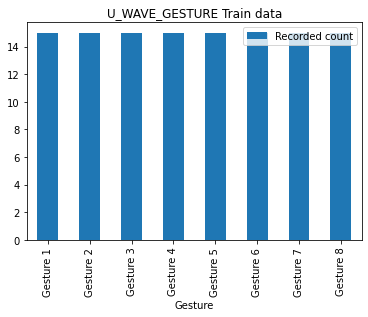

<Figure size 1440x360 with 0 Axes>

In [9]:
draw_class_equilibrium(train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Train data")

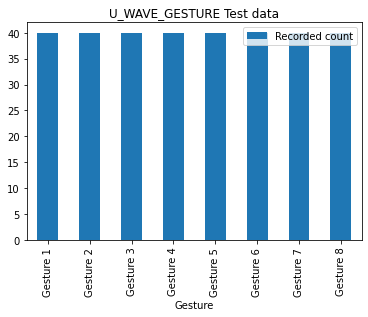

<Figure size 1440x360 with 0 Axes>

In [10]:
draw_class_equilibrium(test_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Test data")


### #1.2 U Wave Gesture axis evolution

##### #1.2.1 Random example for each gesture

In [11]:
def plot_gesture_evolution(chosen_row: pd.Series, class_label_value: str) -> None:
    x_asis_evolution = chosen_row[0]
    y_asis_evolution = chosen_row[1]
    z_asis_evolution = chosen_row[2]
    
    number_of_points = len(x_asis_evolution)
    plot_x_axis = np.linspace(0, number_of_points - 1, number_of_points)
    plt.plot(plot_x_axis, x_asis_evolution, label="X Asis evolution")
    plt.plot(plot_x_axis, y_asis_evolution, label="Y Asis evolution", linestyle=":")
    plt.plot(plot_x_axis, z_asis_evolution, label="Z Asis evolution", linestyle="--")
    plt.xlabel("Time units")
    plt.ylabel("Position")
    plt.title(class_label_value)
    plt.legend()
    plt.figure(figsize=(20, 5))
    plt.show()


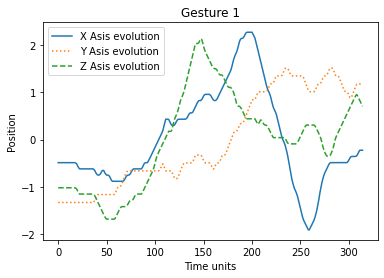

<Figure size 1440x360 with 0 Axes>

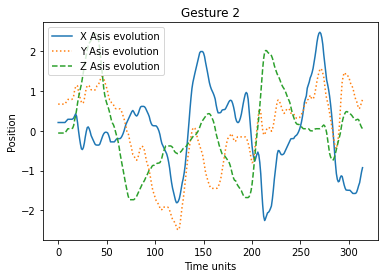

<Figure size 1440x360 with 0 Axes>

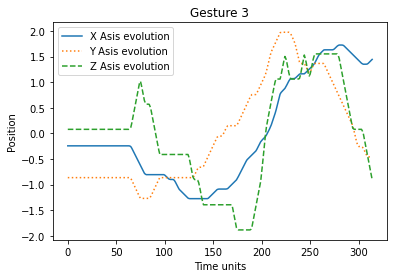

<Figure size 1440x360 with 0 Axes>

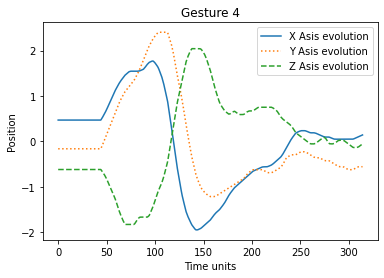

<Figure size 1440x360 with 0 Axes>

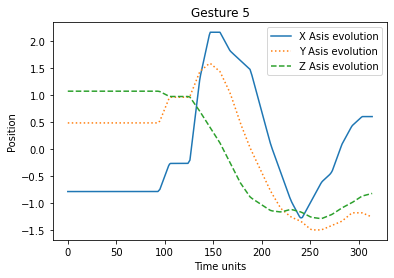

<Figure size 1440x360 with 0 Axes>

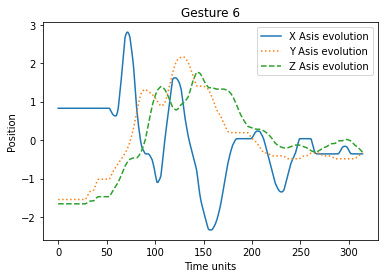

<Figure size 1440x360 with 0 Axes>

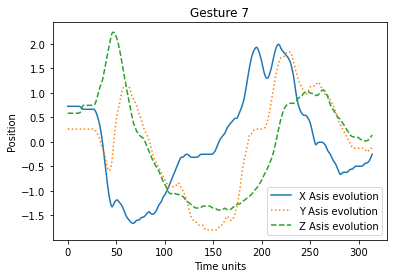

<Figure size 1440x360 with 0 Axes>

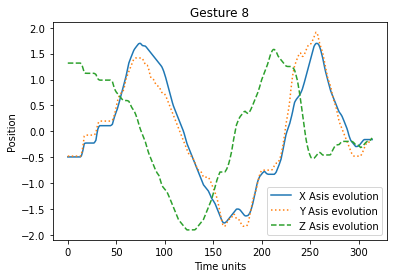

<Figure size 1440x360 with 0 Axes>

In [12]:
for class_label_key in U_WAVE_GESTURE_CLASS_VALUES_MAPPER.keys():
    class_label_value = U_WAVE_GESTURE_CLASS_VALUES_MAPPER[class_label_key]
    current_gesture_data_frame = u_wave_gesture_train_translated.loc[u_wave_gesture_train_translated[U_WAVE_CLASSES_CATEGORY] == class_label_value]
    number_of_rows = len(current_gesture_data_frame.index)
    chosen_index = random.randint(0, number_of_rows - 1)
    chosen_row =  current_gesture_data_frame.iloc[chosen_index]
    plot_gesture_evolution(chosen_row, class_label_value)

##### #1.2.2 Axis evolution distribution per gesture

In [13]:
def plot_axis_evolution(data_frame: pd.DataFrame, column_name: str, classes_category: str) -> None:
    axis_data_frame = data_frame[[column_name, classes_category]]
    
    grouped_by_class= dict()
    for index in range(0, len(axis_data_frame.index)):
        current_row = axis_data_frame.iloc[index]
        values_array = current_row[0]
        correct_class = current_row[1]
        value_for_current_series = values_array.mean()

        if correct_class in grouped_by_class:
            old_array = grouped_by_class[correct_class]
            old_array.append(value_for_current_series)
        else:
            grouped_by_class[correct_class] = [value_for_current_series]

    for correct_class in grouped_by_class:
        correct_class_values_distribution = grouped_by_class[correct_class]
        length = len(correct_class_values_distribution)
        plt.bar([0.0] + correct_class_values_distribution, ["0.0"] + ([correct_class] * length), \
            color=U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER[correct_class], width=(10e-8 * 5), alpha=0.3, label=correct_class)

    plt.xlabel("Mean values")
    plt.ylabel(classes_category)
    plt.legend()
    plt.title("Axis distribution for {} per gesture".format(column_name))
    plt.figure(figsize=(20, 5))
    plt.show()

def plot_all_axis_evolution(data_frame: pd.DataFrame, classes_category: str) -> None:
    plot_axis_evolution(data_frame, "dim_0", classes_category)
    plot_axis_evolution(data_frame, "dim_1", classes_category)
    plot_axis_evolution(data_frame, "dim_2", classes_category)

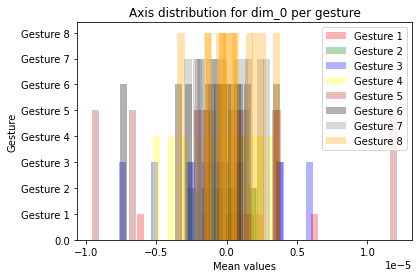

<Figure size 1440x360 with 0 Axes>

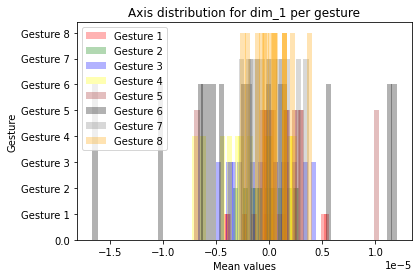

<Figure size 1440x360 with 0 Axes>

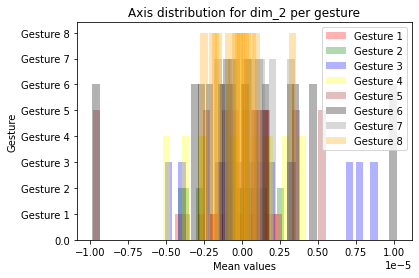

<Figure size 1440x360 with 0 Axes>

In [14]:
plot_all_axis_evolution(u_wave_gesture_train_translated, U_WAVE_CLASSES_CATEGORY)

### #1.3 PEMS-SF Analysis

#### #1.3.1 Best sensors deviation week days

In [15]:
NUMBER_OF_TOP_SENSORS = 10
NUMBER_OF_DAYS = 8

def standard_deviation(element):
    if type(element) == pd.Series:
        return element.std()
    else:
        return element

def fetch_days(data_frame: pd.DataFrame, class_labels: list, classes_category: str):
    new_data_frame = pd.DataFrame(columns=data_frame.columns)
    for class_label in class_labels:
        for days_index in range(0, NUMBER_OF_DAYS): 
            row = data_frame.loc[data_frame[classes_category] == class_label].iloc[days_index]
            new_data_frame.loc[len(new_data_frame.index)] = row
    
    random_row = data_frame.iloc[random.randint(0, len(data_frame.index))] 
    new_data_frame.loc[len(new_data_frame.index)] = random_row

    return new_data_frame

def find_top_sensors_by_std_sum_desc(data_frame : pd.DataFrame, sensors_columns: list) -> list:
    data_frame = data_frame.applymap(standard_deviation)
    sensor_ordered_array = []
    for sensor_column in sensors_columns:
        sensor_standard_deviations = data_frame[sensor_column]
        sensor_sum = sensor_standard_deviations.sum()
        sensor_ordered_array.append((sensor_column, sensor_sum))
    
    sensor_ordered_array.sort(key=lambda pair : pair[1], reverse=True)
    sensor_ordered_array = sensor_ordered_array[0: NUMBER_OF_TOP_SENSORS]
    chosen_sensors = list(map(lambda pair: pair[0], sensor_ordered_array))
    return chosen_sensors

def plot_occupation_rate_deviation_on_days(data_frame: pd.DataFrame, sensors: list, classes_category: str) -> None:
    data_frame = data_frame.applymap(standard_deviation)
    
    for chosen_sensor in sensors:
        sensor_data_frame = data_frame[[chosen_sensor, classes_category]]
        plt.figure(figsize=(20, 5))
        plt.title("Occupation rate variation for sensor {}".format(chosen_sensor))
        plt.xlabel(classes_category)
        plt.ylabel("Occupation rate")
        seaborn.boxplot(x = classes_category, y = chosen_sensor, data = sensor_data_frame)
        plt.show()


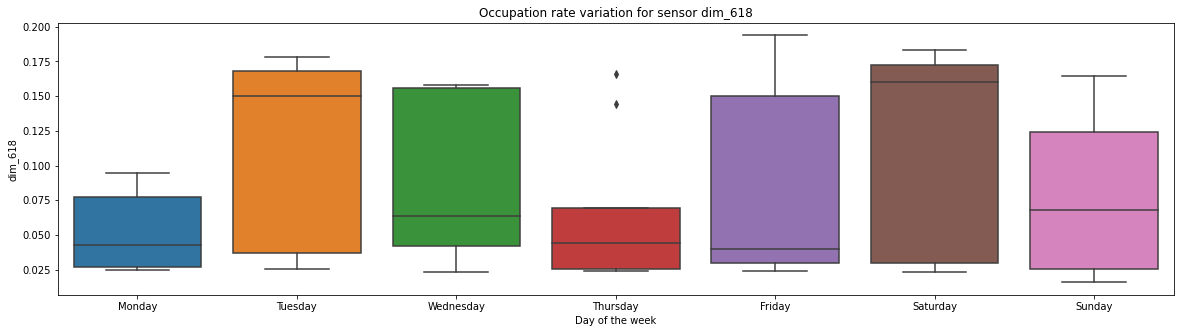

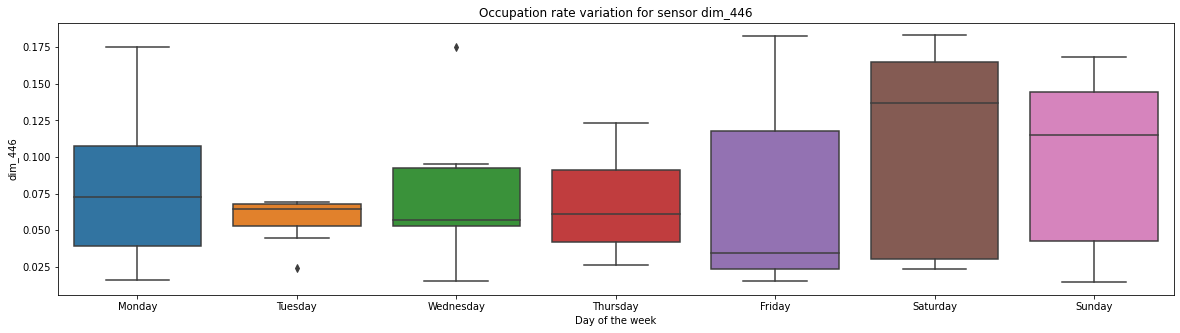

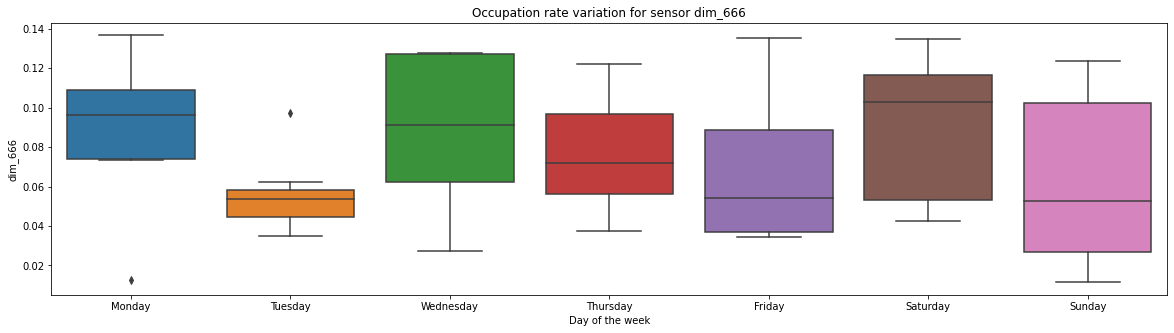

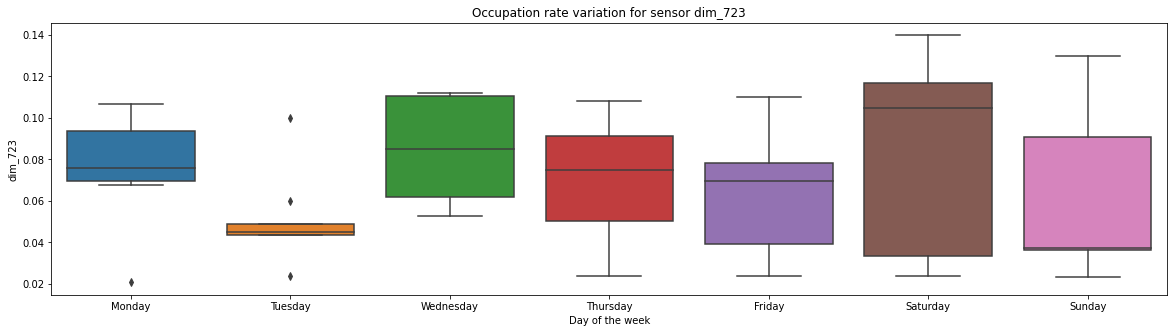

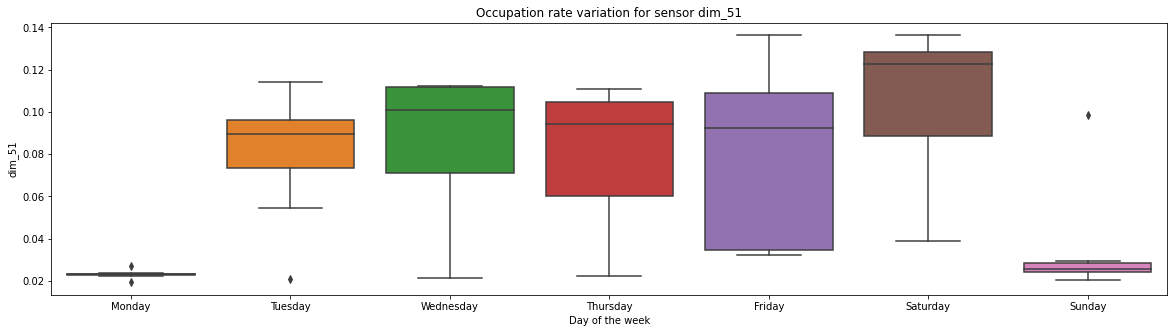

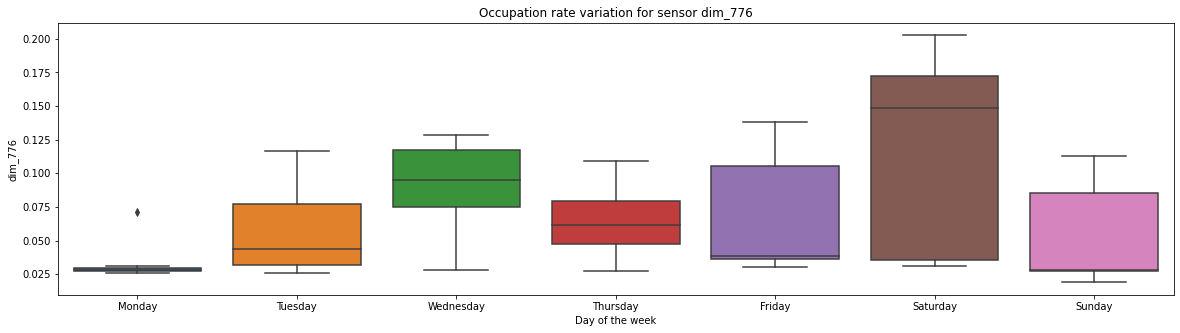

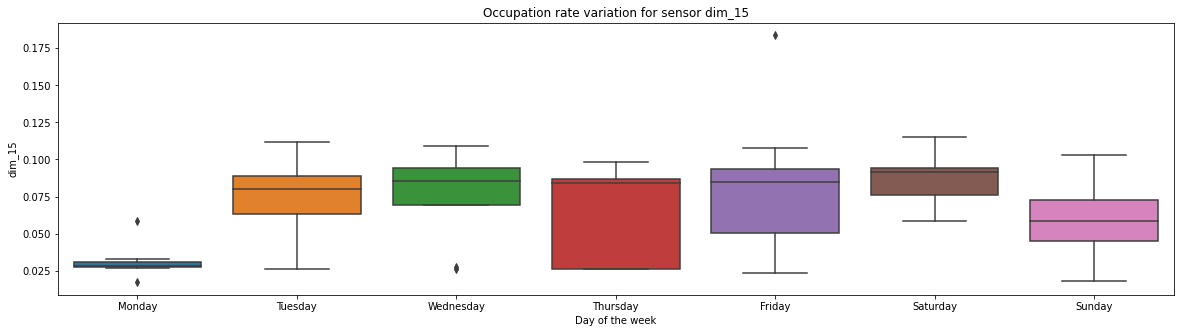

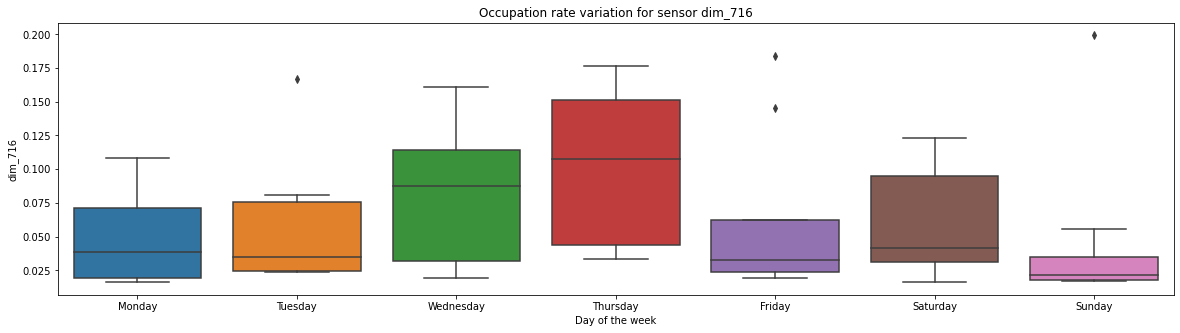

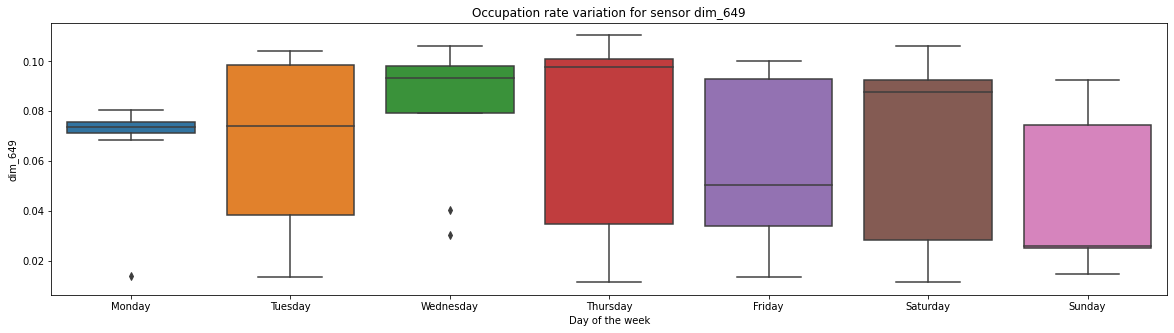

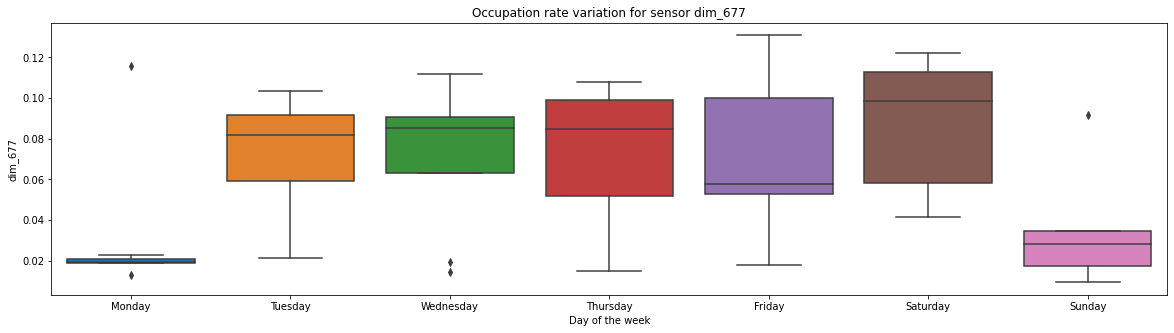

In [16]:
chosen_days_data_frame = fetch_days(pems_sf_train_translated, PEMS_SF_CLASS_VALUES_MAPPER.values(), PEMS_SF_CLASSES_CATEGORY)
chosen_sensors = find_top_sensors_by_std_sum_desc(chosen_days_data_frame, pems_sf_columns)
plot_occupation_rate_deviation_on_days(chosen_days_data_frame, chosen_sensors, PEMS_SF_CLASSES_CATEGORY)

#### #1.3.2 Best sensors occupation rate year evolution

In [17]:
def compute_mean_values_on_columns(data_frame: pd.DataFrame) -> pd.DataFrame:
    return data_frame.applymap(lambda x : x.mean())

def get_top_sensors_by_mean_values_std_desc(data_frame: pd.DataFrame, number_of_sensors: int):
    data_frame = compute_mean_values_on_columns(data_frame)
    return data_frame.std(axis = 0).sort_values(ascending = False)[0:number_of_sensors].index

In [18]:
top_sensors = get_top_sensors_by_mean_values_std_desc(train_x_pems_sf, NUMBER_OF_TOP_SENSORS)
mean_data_frame = compute_mean_values_on_columns(train_x_pems_sf)

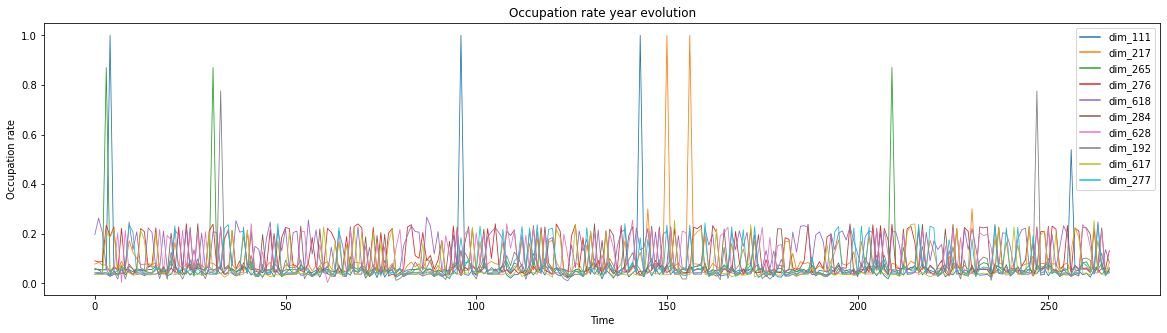

In [19]:
plt.figure(figsize=(20, 5))
plt.title("Occupation rate year evolution")
plt.xlabel("Time")
plt.ylabel("Occupation rate")
seaborn.lineplot(data = mean_data_frame[top_sensors], dashes=False, lw=0.8)
plt.show()

# #2 Feature selection & classic algorithms

## Feature expansion

In [20]:
def get_number_of_lower_peaks(values: pd.Series, peaks_neighbourhood_percentage: float = 0.02) -> int:
    return argrelextrema(np.array(values), np.less_equal, order = int(len(values) * peaks_neighbourhood_percentage) )[0].size 

def get_number_of_higher_peaks(values: pd.Series, peaks_neighbourhood_percentage: float = 0.02) -> int:
    return argrelextrema(np.array(values), np.greater_equal, order = int(len(values) * peaks_neighbourhood_percentage) )[0].size 

def compute_resulting_medium_acceleration_on_row(row: pd.Series, columns: list) -> float:
    list_of_squared_values = []
    for column_name in columns:
        squared_value = math.sqrt(sum(map(lambda value: value ** 2, row[column_name])))
        list_of_squared_values.append(squared_value)
    return pd.Series(list_of_squared_values).mean()

def compute_signal_area(row: pd.Series, columns: list) -> float:
    list_of_squared_values = []
    for column_name in columns:
        list_of_squared_values.append(abs(row[column_name]).mean())
    return pd.Series(list_of_squared_values).sum()

def expand_u_wave_gesture_data_set(data_set: pd.DataFrame):
    new_data_set = pd.DataFrame()
    columns = data_set.columns 
    for column_name in columns:
        current_column_data_set = data_set[column_name]

        new_data_set["mean_" + column_name] = current_column_data_set.apply(lambda x : abs(x.mean()))
        new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : abs(x.std()))
        new_data_set["max_" + column_name] = current_column_data_set.apply(lambda x : abs(x.max()))
        new_data_set["min_" + column_name] = current_column_data_set.apply(lambda x : abs(x.min()))
        new_data_set["difference_" + column_name] = current_column_data_set.apply(lambda x : abs(x.max() - x.min()))
        new_data_set["skew_" + column_name] = current_column_data_set.apply(lambda x : abs(x.skew()))
        new_data_set["kurtosis_" + column_name] = current_column_data_set.apply(lambda x : abs(x.kurtosis()))
        new_data_set["mean_absolute_deviaton_" + column_name] = current_column_data_set.apply(lambda x : abs(x.mad()))
        new_data_set["interquartile_interval_" + column_name] = current_column_data_set.apply(lambda x : abs(np.percentile(x, 25) - np.percentile(x, 75)))
        new_data_set["median_" + column_name] = current_column_data_set.apply(lambda x : abs(x.median()))
        new_data_set["number_of_positives_" + column_name] = current_column_data_set.apply(lambda x : len(x.loc[x >= 0]))
        new_data_set["number_of_negatives_" + column_name] = current_column_data_set.apply(lambda x : len(x.loc[x < 0]))
        new_data_set["number_of_greater_than_mean_" + column_name] = current_column_data_set.apply(lambda x : len(x.loc[x > x.mean()]))
        new_data_set["number_of_higher_peaks_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_higher_peaks(x))
        new_data_set["signal_energy_" + column_name] = current_column_data_set.apply(lambda x : sum(map(lambda value : value**2, x)) / len(x) )

    new_data_set["resulting_medium_acceleration"] = data_set.apply(lambda row: compute_resulting_medium_acceleration_on_row(row, columns), axis = 1)
    new_data_set["signal_area"] = data_set.apply(lambda row: compute_signal_area(row, columns), axis = 1)

    return new_data_set

def expand_pems_sf_data_set(data_set: pd.DataFrame):
    new_data_set = pd.DataFrame()
    for column_name in data_set.columns:
        current_column_data_set = data_set[column_name]
        new_data_set["mean_" + column_name] = current_column_data_set.apply(lambda x : x.mean())
        new_data_set["number_of_lower_peaks_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_lower_peaks(x))
        new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
        new_data_set["max_" + column_name] = current_column_data_set.apply(lambda x : x.max())
        new_data_set["min_" + column_name] = current_column_data_set.apply(lambda x : x.min())
        new_data_set["difference_" + column_name] = current_column_data_set.apply(lambda x : abs(x.max() - x.min()))
        new_data_set["25_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 25))
        new_data_set["50_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 50))
        new_data_set["75_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 75))
        new_data_set["skew_" + column_name] = current_column_data_set.apply(lambda x : abs(x.skew()))
        new_data_set["kurtosis_" + column_name] = current_column_data_set.apply(lambda x : abs(x.kurtosis()))
    return new_data_set

In [21]:
# PEMS-SF
train_x_pems_sf_expanded = expand_pems_sf_data_set(train_x_pems_sf)
test_x_pems_sf_expanded = expand_pems_sf_data_set(test_x_pems_sf)

# U Wave Gesture
train_x_u_wave_gesture_expanded = expand_u_wave_gesture_data_set(train_x_u_wave_gesture)
test_x_u_wave_gesture_expanded = expand_u_wave_gesture_data_set(test_x_u_wave_gesture)

/tmp/ipykernel_3219/3443301253.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["number_of_lower_peaks_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_lower_peaks(x))
/tmp/ipykernel_3219/3443301253.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
/tmp/ipykernel_3219/3443301253.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

## Feature selection

In [22]:
def select_features(X: pd.DataFrame, y : pd.DataFrame, variance_threshold_percentage = 0.6, percentile=25) -> pd.DataFrame:
    X = VarianceThreshold(threshold=(variance_threshold_percentage * (1 - variance_threshold_percentage))).fit_transform(X)
    X = SelectPercentile(chi2, percentile=percentile).fit_transform(X, y)
    return pd.DataFrame(X)

def combine_and_select_features(
        X_train: pd.DataFrame, y_train: pd.DataFrame,
        X_test: pd.DataFrame, y_test: pd.DataFrame) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    X_train_rows = len(X_train)

    X = pd.concat([X_train, X_test])
    y = np.concatenate((y_train, y_test))

    print("Number of features after expansion = ", len(X.columns))
    X_filtered = select_features(X, y)
    print("Number of features after selection = ", len(X_filtered.columns))
    
    return (X_filtered[0:X_train_rows], X_filtered[X_train_rows: len(X_filtered)])

In [23]:
# PEMS-SF
print("Selecting PEMS-SF features")
train_x_pems_sf_filtered, test_x_pems_sf_filtered = combine_and_select_features(
    train_x_pems_sf_expanded, train_y_pems_sf,
    test_x_pems_sf_expanded, test_y_pems_sf)

# U Wave Gesture
print("\nSelecting U Wave Gesture features")
train_x_u_wave_gesture_filtered, test_x_u_wave_gesture_filtered = combine_and_select_features(
    train_x_u_wave_gesture_expanded, train_y_u_wave_gesture,
    test_x_u_wave_gesture_expanded, test_y_u_wave_gesture)

Selecting PEMS-SF features
Number of features after expansion =  10593
Number of features after selection =  708

Selecting U Wave Gesture features
Number of features after expansion =  47
Number of features after selection =  5


## #2.1 PEMS-SF

### #2.1.1 Random forest

In [24]:
random_forest_parameters = {
    "max_depth": [5, 10, 15, 20],
    "n_estimators" : [10, 100, 200, 500],
    "min_samples_split" : [2, 5, 7]
}

random_forest_grid_search_result = compute_grid_search_result(
    RandomForestClassifier(),
    random_forest_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf)

random_forest_result = fit_predict_and_compute_metrics(
    RandomForestClassifier,
    random_forest_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf,
    test_x_pems_sf_filtered,
    test_y_pems_sf
)

pems_sf_results["random_forest"] = random_forest_result
random_forest_result

{'accuracy_score': 0.8786127167630058,
 'precision_score': array([1.        , 1.        , 1.        , 0.7826087 , 0.9       ,
        0.75      , 0.76923077]),
 'recall_score': array([0.86666667, 1.        , 0.80769231, 0.7826087 , 0.81818182,
        0.88888889, 1.        ]),
 'f1_score': array([0.92857143, 1.        , 0.89361702, 0.7826087 , 0.85714286,
        0.81355932, 0.86956522]),
 'confusion_matrix': array([[26,  0,  0,  0,  0,  0,  4],
        [ 0, 25,  0,  0,  0,  0,  0],
        [ 0,  0, 21,  5,  0,  0,  0],
        [ 0,  0,  0, 18,  1,  4,  0],
        [ 0,  0,  0,  0, 18,  4,  0],
        [ 0,  0,  0,  0,  1, 24,  2],
        [ 0,  0,  0,  0,  0,  0, 20]]),
 'parameters': {'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 500}}

### #2.1.2 SVM

In [25]:
svm_parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [1, 2, 3, 4, 5],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : ['scale', 'auto']
}

svm_grid_search_result = compute_grid_search_result(
    SVC(),
    svm_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf)

svm_result = fit_predict_and_compute_metrics(
    SVC,
    svm_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf,
    test_x_pems_sf_filtered,
    test_y_pems_sf
)

pems_sf_results["svm"] = svm_result
svm_result

{'accuracy_score': 0.7167630057803468,
 'precision_score': array([0.82758621, 0.85714286, 0.66666667, 0.59090909, 0.7       ,
        0.6       , 0.81818182]),
 'recall_score': array([0.8       , 0.72      , 0.61538462, 0.56521739, 0.63636364,
        0.77777778, 0.9       ]),
 'f1_score': array([0.81355932, 0.7826087 , 0.64      , 0.57777778, 0.66666667,
        0.67741935, 0.85714286]),
 'confusion_matrix': array([[24,  0,  0,  0,  0,  2,  4],
        [ 3, 18,  0,  2,  0,  2,  0],
        [ 0,  2, 16,  4,  2,  2,  0],
        [ 0,  0,  3, 13,  2,  5,  0],
        [ 0,  0,  2,  3, 14,  3,  0],
        [ 0,  1,  3,  0,  2, 21,  0],
        [ 2,  0,  0,  0,  0,  0, 18]]),
 'parameters': {'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}}

### #2.1.3 Gradient Boosted Trees

In [26]:
xgb_parameters = {
    'max_depth': [2, 4, 5],
    'n_estimators': [5, 50, 100],
    'learning_rate': [0.05, 0.1],
}

xgb_grid_search_result = compute_grid_search_result(
    XGBClassifier(),
    xgb_parameters,
    train_x_pems_sf_filtered,
    train_y_pems_sf)

xgb_result = fit_predict_and_compute_metrics(
    XGBClassifier,
    xgb_grid_search_result.best_params_,
    train_x_pems_sf_filtered,
    train_y_pems_sf,
    test_x_pems_sf_filtered,
    test_y_pems_sf
)

pems_sf_results["xgb"] = xgb_result
xgb_result

{'accuracy_score': 0.930635838150289,
 'precision_score': array([1.        , 0.88888889, 0.96      , 1.        , 0.91666667,
        0.92592593, 0.83333333]),
 'recall_score': array([0.86666667, 0.96      , 0.92307692, 0.86956522, 1.        ,
        0.92592593, 1.        ]),
 'f1_score': array([0.92857143, 0.92307692, 0.94117647, 0.93023256, 0.95652174,
        0.92592593, 0.90909091]),
 'confusion_matrix': array([[26,  0,  0,  0,  0,  2,  2],
        [ 0, 24,  1,  0,  0,  0,  0],
        [ 0,  0, 24,  0,  2,  0,  0],
        [ 0,  3,  0, 20,  0,  0,  0],
        [ 0,  0,  0,  0, 22,  0,  0],
        [ 0,  0,  0,  0,  0, 25,  2],
        [ 0,  0,  0,  0,  0,  0, 20]]),
 'parameters': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}}

## #2.2 U Wave Gesture

### #2.2.1 Random forest

In [27]:
random_forest_parameters = {
    "max_depth": [5, 10, 15, 20],
    "n_estimators" : [10, 100, 200, 500],
    "min_samples_split" : [2, 5, 7]
}

random_forest_grid_search_result = compute_grid_search_result(
    RandomForestClassifier(),
    random_forest_parameters,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture)

random_forest_result = fit_predict_and_compute_metrics(
    RandomForestClassifier,
    random_forest_grid_search_result.best_params_,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture,
    test_x_u_wave_gesture_filtered,
    test_y_u_wave_gesture
)

u_wave_gesture_results["random_forest"] = random_forest_result
random_forest_result

{'accuracy_score': 0.384375,
 'precision_score': array([0.33333333, 0.65789474, 0.36      , 0.23809524, 0.45833333,
        0.37837838, 0.39473684, 0.27027027]),
 'recall_score': array([0.625, 0.625, 0.45 , 0.125, 0.275, 0.35 , 0.375, 0.25 ]),
 'f1_score': array([0.43478261, 0.64102564, 0.4       , 0.16393443, 0.34375   ,
        0.36363636, 0.38461538, 0.25974026]),
 'confusion_matrix': array([[25,  0,  5,  4,  1,  1,  2,  2],
        [ 2, 25,  0,  0,  0,  0,  7,  6],
        [ 6,  0, 18,  5,  2,  8,  0,  1],
        [ 6,  0, 16,  5,  5,  5,  0,  3],
        [11,  1,  4,  1, 11,  9,  0,  3],
        [ 6,  0,  7,  6,  5, 14,  0,  2],
        [10,  5,  0,  0,  0,  0, 15, 10],
        [ 9,  7,  0,  0,  0,  0, 14, 10]]),
 'parameters': {'max_depth': 5, 'min_samples_split': 7, 'n_estimators': 10}}

### #2.2.2 SVM

In [28]:
svm_parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [1, 2, 3, 4, 5],
    'degree': [1, 2, 3, 4, 5],
    'gamma' : ['scale', 'auto']
}

svm_grid_search_result = compute_grid_search_result(
    SVC(),
    svm_parameters,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture)

svm_result = fit_predict_and_compute_metrics(
    SVC,
    svm_grid_search_result.best_params_,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture,
    test_x_u_wave_gesture_filtered,
    test_y_u_wave_gesture
)

u_wave_gesture_results["svm"] = svm_result
svm_result

{'accuracy_score': 0.403125,
 'precision_score': array([0.29487179, 0.60465116, 0.5       , 0.3125    , 0.43478261,
        0.39473684, 0.39285714, 0.39583333]),
 'recall_score': array([0.575, 0.65 , 0.375, 0.25 , 0.25 , 0.375, 0.275, 0.475]),
 'f1_score': array([0.38983051, 0.62650602, 0.42857143, 0.27777778, 0.31746032,
        0.38461538, 0.32352941, 0.43181818]),
 'confusion_matrix': array([[23,  0,  0,  6,  0,  3,  3,  5],
        [ 4, 26,  0,  0,  0,  0,  5,  5],
        [ 6,  1, 15, 12,  2,  4,  0,  0],
        [ 8,  0, 11, 10,  4,  4,  0,  3],
        [10,  3,  2,  0, 10, 12,  1,  2],
        [11,  0,  2,  4,  7, 15,  0,  1],
        [11,  5,  0,  0,  0,  0, 11, 13],
        [ 5,  8,  0,  0,  0,  0,  8, 19]]),
 'parameters': {'C': 4, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}}

### #2.2.3 Gradient Boosted Trees

In [29]:
xgb_parameters = {
    'max_depth': [2, 4, 5],
    'n_estimators': [5, 50, 100],
    'learning_rate': [0.05, 0.1],
}

xgb_grid_search_result = compute_grid_search_result(
    XGBClassifier(),
    xgb_parameters,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture)

xgb_result = fit_predict_and_compute_metrics(
    XGBClassifier,
    xgb_grid_search_result.best_params_,
    train_x_u_wave_gesture_filtered,
    train_y_u_wave_gesture,
    test_x_u_wave_gesture_filtered,
    test_y_u_wave_gesture
)

u_wave_gesture_results["xgb"] = xgb_result
xgb_result

{'accuracy_score': 0.35625,
 'precision_score': array([0.3442623 , 0.55813953, 0.31111111, 0.28571429, 0.33333333,
        0.32692308, 0.32258065, 0.31818182]),
 'recall_score': array([0.525, 0.6  , 0.35 , 0.1  , 0.25 , 0.425, 0.25 , 0.35 ]),
 'f1_score': array([0.41584158, 0.57831325, 0.32941176, 0.14814815, 0.28571429,
        0.36956522, 0.28169014, 0.33333333]),
 'confusion_matrix': array([[21,  1,  3,  2,  3,  3,  3,  4],
        [ 5, 24,  0,  0,  0,  0,  4,  7],
        [ 6,  1, 14,  8,  2,  8,  1,  0],
        [ 4,  0, 14,  4,  5,  9,  0,  4],
        [ 6,  1,  6,  0, 10, 15,  1,  1],
        [ 7,  0,  8,  0,  7, 17,  0,  1],
        [ 6, 10,  0,  0,  1,  0, 10, 13],
        [ 6,  6,  0,  0,  2,  0, 12, 14]]),
 'parameters': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 5}}

# #3 Neural networks

## Data preparation

In [30]:
def expand_u_wave_gesture_data_set_for_neural_networks(data_set: pd.DataFrame):
    columns = data_set.columns 
    series_length = len(data_set.iloc[0][0])

    final_columns = []
    for column in columns:
        for series_index in range(0, series_length):
            final_columns.append("{}_{}".format(column, series_index))
    new_data_set = pd.DataFrame(columns = final_columns)

    for row_index in range(0, len(data_set)):
        row = data_set.iloc[row_index]
        
        new_row = []
        for column in columns:
            new_row += list(row[column])
        
        new_data_set.loc[row_index] = new_row

    return new_data_set

In [31]:
train_x_u_wave_gesture_expanded_neural_networks = expand_u_wave_gesture_data_set_for_neural_networks(train_x_u_wave_gesture)
test_x_u_wave_gesture_expanded_neural_networks = expand_u_wave_gesture_data_set_for_neural_networks(test_x_u_wave_gesture)

## U Wave Gesture

### #3.2.1 Multi-Layered Perceptron

In [32]:
def get_layers(number_of_layers, number_of_neurons_per_layer):
    return tuple((number_of_neurons_per_layer for x in range(0, number_of_layers)))

mlp_parameters = {
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'learning_rate': 'constant',
    'hidden_layer_sizes' : get_layers(5, 100),
    'max_iter' : int(1e5)
}

mlp_result = fit_predict_and_compute_metrics(
    MLPClassifier,
    mlp_parameters,
    train_x_u_wave_gesture_expanded_neural_networks,
    train_y_u_wave_gesture,
    test_x_u_wave_gesture_expanded_neural_networks,
    test_y_u_wave_gesture
)

u_wave_gesture_results["mlp"] = mlp_result
mlp_result

{'accuracy_score': 0.825,
 'precision_score': array([0.85365854, 0.9047619 , 0.84615385, 0.86666667, 0.62962963,
        0.65909091, 1.        , 0.97368421]),
 'recall_score': array([0.875, 0.95 , 0.825, 0.65 , 0.85 , 0.725, 0.8  , 0.925]),
 'f1_score': array([0.86419753, 0.92682927, 0.83544304, 0.74285714, 0.72340426,
        0.69047619, 0.88888889, 0.94871795]),
 'confusion_matrix': array([[35,  0,  0,  0,  0,  5,  0,  0],
        [ 0, 38,  0,  0,  0,  2,  0,  0],
        [ 0,  0, 33,  0,  7,  0,  0,  0],
        [ 0,  0,  0, 26, 12,  2,  0,  0],
        [ 1,  0,  1,  0, 34,  3,  0,  1],
        [ 4,  0,  3,  4,  0, 29,  0,  0],
        [ 0,  4,  2,  0,  1,  1, 32,  0],
        [ 1,  0,  0,  0,  0,  2,  0, 37]]),
 'parameters': {'activation': 'relu',
  'solver': 'adam',
  'alpha': 0.001,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (100, 100, 100, 100, 100),
  'max_iter': 100000}}

### #3.2.2 Convolutional Neural Network

In [33]:
def build_cnn_model(input_shape, output_shape, filters = 64, filter_size = 3):
    filters = 64
    filter_size = 3

    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters, filter_size, activation="relu", padding="same", input_shape=input_shape),
    tf.keras.layers.Conv1D(filters, filter_size, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dense(output_shape, activation="softmax")
    ])
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='adam')    
    model.compile(optimizer=adam, loss=loss_fn, metrics=['accuracy'])
    return model

In [34]:
# train
train_x_cnn = get_np_array_from_data_frame(train_x_u_wave_gesture)
train_x_cnn = np.array(list(map(lambda x: x.transpose(), train_x_cnn)))
train_y_cnn = tf.keras.utils.to_categorical(train_y_u_wave_gesture)

# test
test_x_cnn = get_np_array_from_data_frame(test_x_u_wave_gesture)
test_x_cnn = np.array(list(map(lambda x: x.transpose(), test_x_cnn)))
test_y_cnn = test_y_u_wave_gesture

In [59]:
cnn_model = build_cnn_model(train_x_cnn.shape[1:], train_y_cnn.shape[1])
cnn_result = fit_predict_and_compute_metrics_nn(\
    cnn_model, train_x_cnn, train_y_cnn, test_x_cnn, test_y_cnn, batch_size=32, epochs=10, verbose=0)

u_wave_gesture_results["cnn"] = cnn_result
cnn_result

{'accuracy_score': 0.859375,
 'precision_score': array([0.94594595, 0.86666667, 0.8372093 , 0.86666667, 0.74      ,
        0.85365854, 0.88235294, 0.925     ]),
 'recall_score': array([0.875, 0.975, 0.9  , 0.65 , 0.925, 0.875, 0.75 , 0.925]),
 'f1_score': array([0.90909091, 0.91764706, 0.86746988, 0.74285714, 0.82222222,
        0.86419753, 0.81081081, 0.925     ]),
 'confusion_matrix': array([[35,  0,  1,  0,  0,  4,  0,  0],
        [ 0, 39,  0,  0,  0,  1,  0,  0],
        [ 0,  0, 36,  1,  1,  0,  2,  0],
        [ 0,  0,  0, 26, 11,  1,  0,  2],
        [ 0,  1,  1,  0, 37,  0,  1,  0],
        [ 0,  0,  2,  2,  0, 35,  1,  0],
        [ 0,  5,  3,  1,  0,  0, 30,  1],
        [ 2,  0,  0,  0,  1,  0,  0, 37]])}

### #3.2.3 Long short-term memory

In [36]:
def build_lstm_model(input_shape, output_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(1000, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1000, activation='relu'))
    model.add(tf.keras.layers.Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
train_x = get_np_array_from_data_frame(train_x_u_wave_gesture)
train_y = tf.keras.utils.to_categorical(train_y_u_wave_gesture)

test_x = get_np_array_from_data_frame(test_x_u_wave_gesture)
test_y = test_y_u_wave_gesture

In [38]:
lstm_model = build_lstm_model(train_x.shape[1:], train_y.shape[1])
lstm_result = fit_predict_and_compute_metrics_nn(lstm_model, train_x, train_y, test_x, test_y, batch_size=5, epochs=10, verbose=0)

u_wave_gesture_results["lstm"] = lstm_result
lstm_result

{'accuracy_score': 0.86875,
 'precision_score': array([0.92307692, 0.95238095, 0.85365854, 0.92307692, 0.65454545,
        0.80487805, 1.        , 0.95121951]),
 'recall_score': array([0.9  , 1.   , 0.875, 0.6  , 0.9  , 0.825, 0.875, 0.975]),
 'f1_score': array([0.91139241, 0.97560976, 0.86419753, 0.72727273, 0.75789474,
        0.81481481, 0.93333333, 0.96296296]),
 'confusion_matrix': array([[36,  0,  1,  0,  0,  3,  0,  0],
        [ 0, 40,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 35,  0,  4,  1,  0,  0],
        [ 0,  0,  0, 24, 14,  1,  0,  1],
        [ 0,  0,  1,  0, 36,  2,  0,  1],
        [ 3,  0,  1,  2,  1, 33,  0,  0],
        [ 0,  2,  3,  0,  0,  0, 35,  0],
        [ 0,  0,  0,  0,  0,  1,  0, 39]])}

# #4 Final overview

In [60]:
def plot_algorithms_accuracy(execution_results, data_set_name, width = 0.25):
    algorithms = list(execution_results.keys())
    accuracy_scores = []
    for key in execution_results.keys():
        value = execution_results[key]
        accuracy_scores.append(value["accuracy_score"] * 100)
    
    plt.figure(figsize=(20, 5))
    plt.bar(algorithms, accuracy_scores, color ='green', width = width)

    plt.xlabel("Algorithms")
    plt.ylabel('Scores')
    plt.title("{} algorithms accuracy".format(data_set_name))
    plt.show()

def plot_algorithm_overview(data_set_name, algorithm, execution_result, class_labels, width = 0.15):
    x_axis = np.arange(len(class_labels.values()))
    
    plt.figure(figsize=(20, 5))
    plt.bar(x_axis, execution_result["precision_score"], color ='red', width=width, label="Precision score")
    plt.bar(x_axis + 0.2, execution_result["recall_score"], color ='green', width=width, label="Recall score")
    plt.bar(x_axis + 0.4, execution_result["f1_score"], color ='blue', width = width, label="F1 score")

    plt.xlabel("Classes")
    plt.ylabel("Scores")
    plt.xticks(x_axis, class_labels.values())
    plt.title("{} {} score class distribution".format(data_set_name, algorithm))
    plt.legend()
    plt.show()


## #4.1 PEMS-SF

### 4.1.1 Accuracy

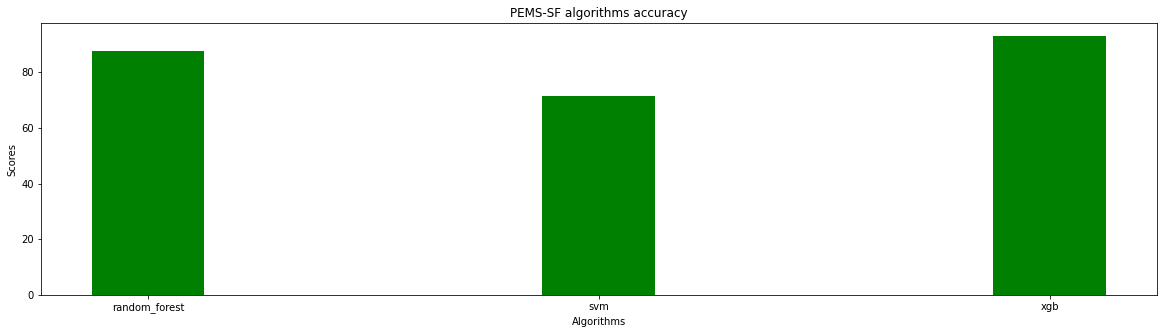

In [61]:
plot_algorithms_accuracy(pems_sf_results, "PEMS-SF")

### 4.1.2 Algorithms efficiency with respect to classes

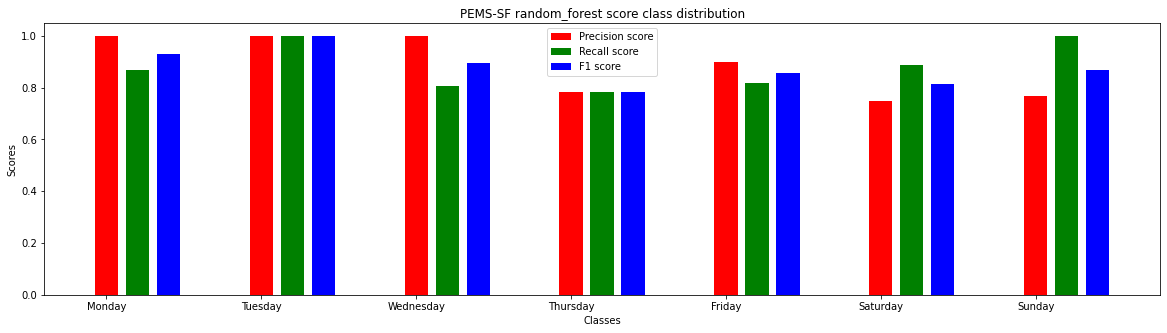

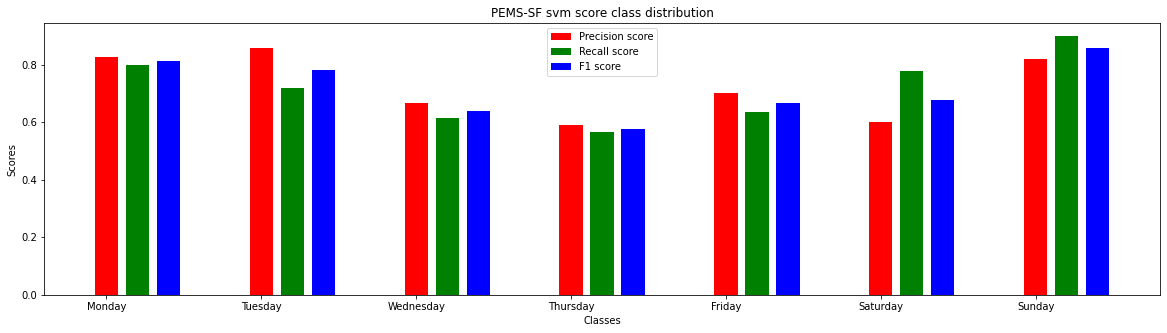

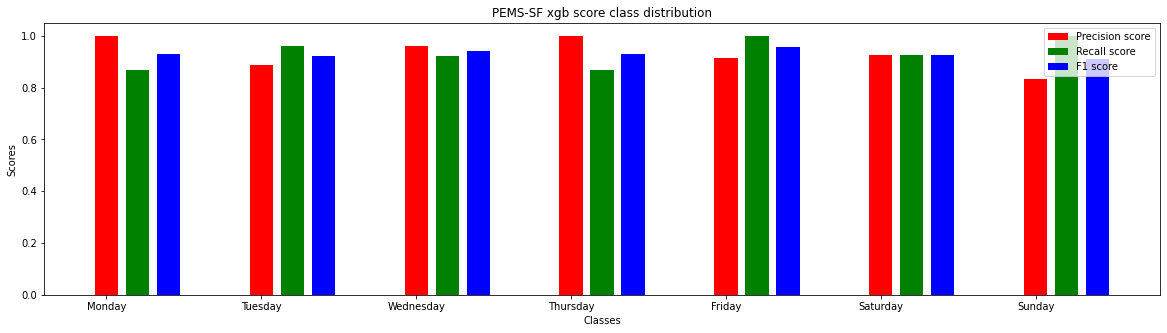

In [56]:
for algorithm in pems_sf_results.keys():
    plot_algorithm_overview("PEMS-SF", algorithm, pems_sf_results[algorithm], PEMS_SF_CLASS_VALUES_MAPPER)

## #4.2 U Wave Gesture

### #4.2.1 Accuracy

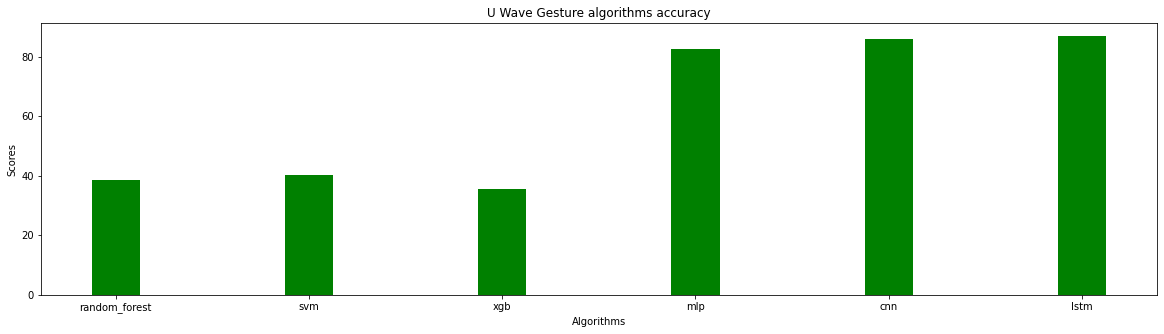

In [62]:
plot_algorithms_accuracy(u_wave_gesture_results, "U Wave Gesture")

### #4.2.2 Algorithms efficiency with respect to classes

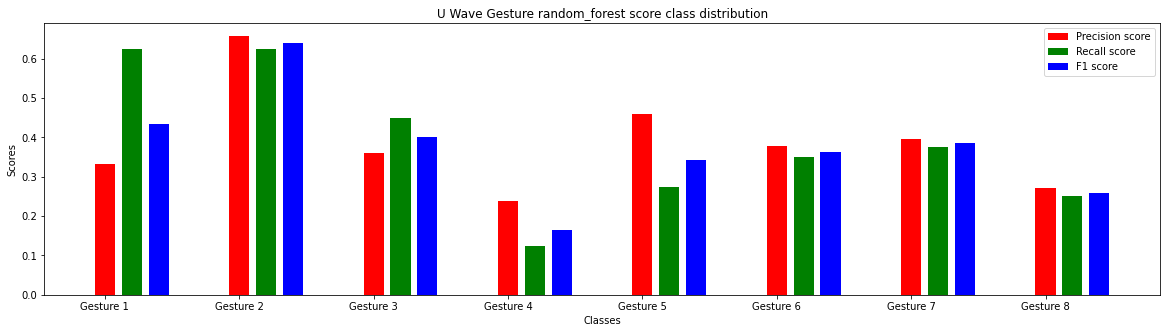

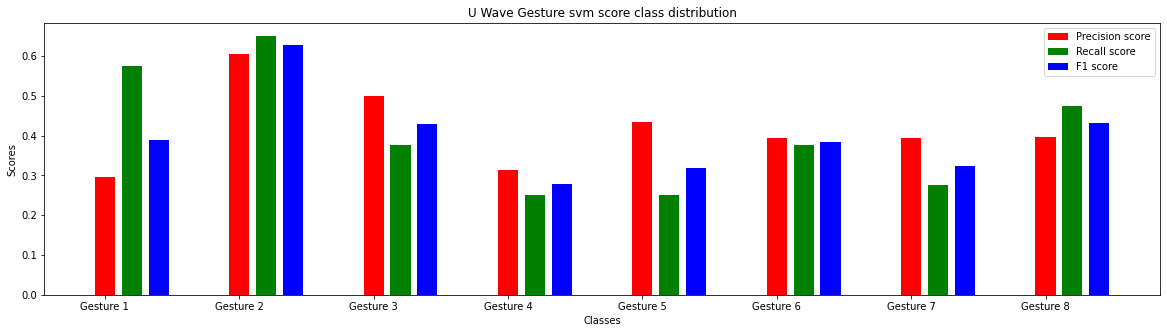

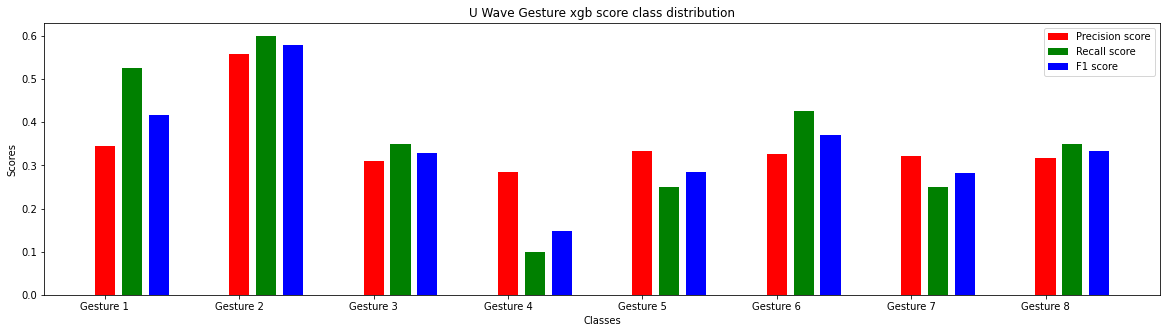

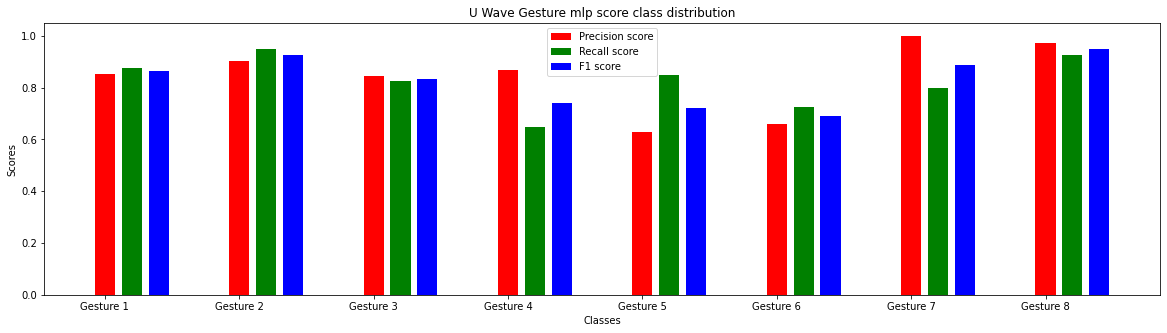

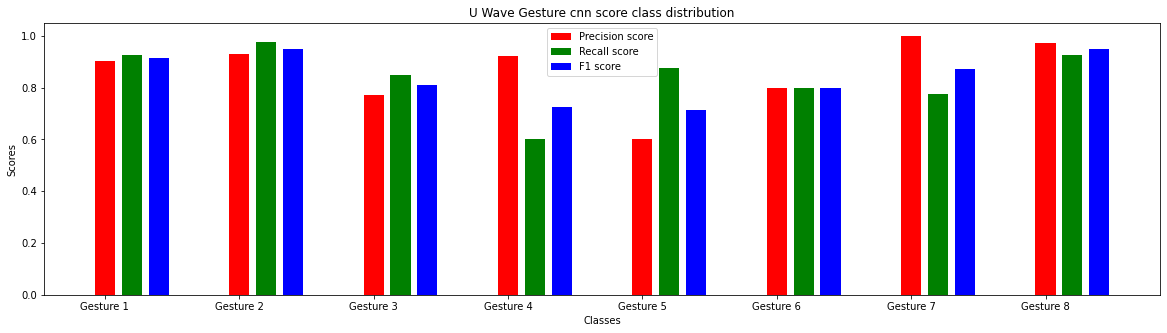

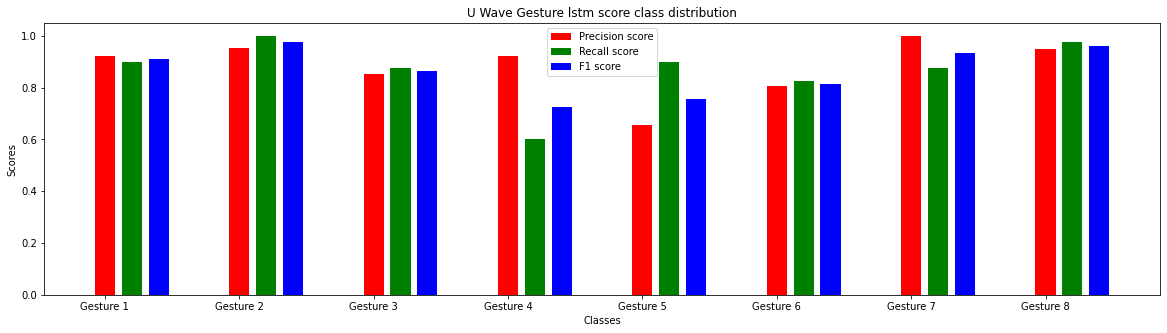

In [58]:
for algorithm in u_wave_gesture_results.keys():
    plot_algorithm_overview("U Wave Gesture", algorithm, u_wave_gesture_results[algorithm], U_WAVE_GESTURE_CLASS_VALUES_MAPPER)